## Cohort Retention Analysis

**Remark**: I took the reference from this great post [Bayesian Age/Period/Cohort](https://www.austinrochford.com/posts/apc-pymc.html) Models in Python with PyMC.



In [1]:
import arviz as az
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from scipy.special import expit
from sklearn.preprocessing import LabelEncoder, StandardScaler

c:\Users\raviteja.kurva\Anaconda3\envs\pymc_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Read the data 

**Remark**: This dataset is synthetic dataset

In [8]:
data_df = pd.read_csv('Input_data/Cohort_data.csv')

data_df['cohort'] = pd.to_datetime(data_df['cohort'])
data_df['period'] = pd.to_datetime(data_df['period'])

In [9]:
data_df

,cohort,n_users,period,age,cohort_age,n_active_users,retention
0,2020-01-01,150,2020-01-01,1430,0,150,1.000000
1,2020-01-01,150,2020-02-01,1430,31,25,0.166667
2,2020-01-01,150,2020-03-01,1430,60,13,0.086667
3,2020-01-01,150,2020-04-01,1430,91,6,0.040000
4,2020-01-01,150,2020-05-01,1430,121,2,0.013333
...,...,...,...,...,...,...,...
1171,2023-10-01,10891,2023-11-01,61,31,2541,0.233312
1172,2023-10-01,10891,2023-12-01,61,61,1487,0.136535
1173,2023-11-01,4769,2023-11-01,30,0,4769,1.000000
1174,2023-11-01,4769,2023-12-01,30,30,861,0.180541


In order to assess our model's out-of-sample predictions, we now do a train-test split.

In [10]:
# Define the train-test split date
period_train_test_split = "2023-06-01"

# Filter train data
train_data_df = data_df[data_df["period"] <= period_train_test_split]

# Filter test data based on period and common cohorts with train data
test_data_df = data_df[(data_df["period"] > period_train_test_split) & 
                       (data_df["cohort"].isin(train_data_df["cohort"].unique()))]

#### Explorarty Data Analysis

Let's examine the statistics right away. We only use the training data even though we would really like to use the test data as a hold-out set. We first depict the total number of users for each cohort as well as the total number of users who returned for each cohort.

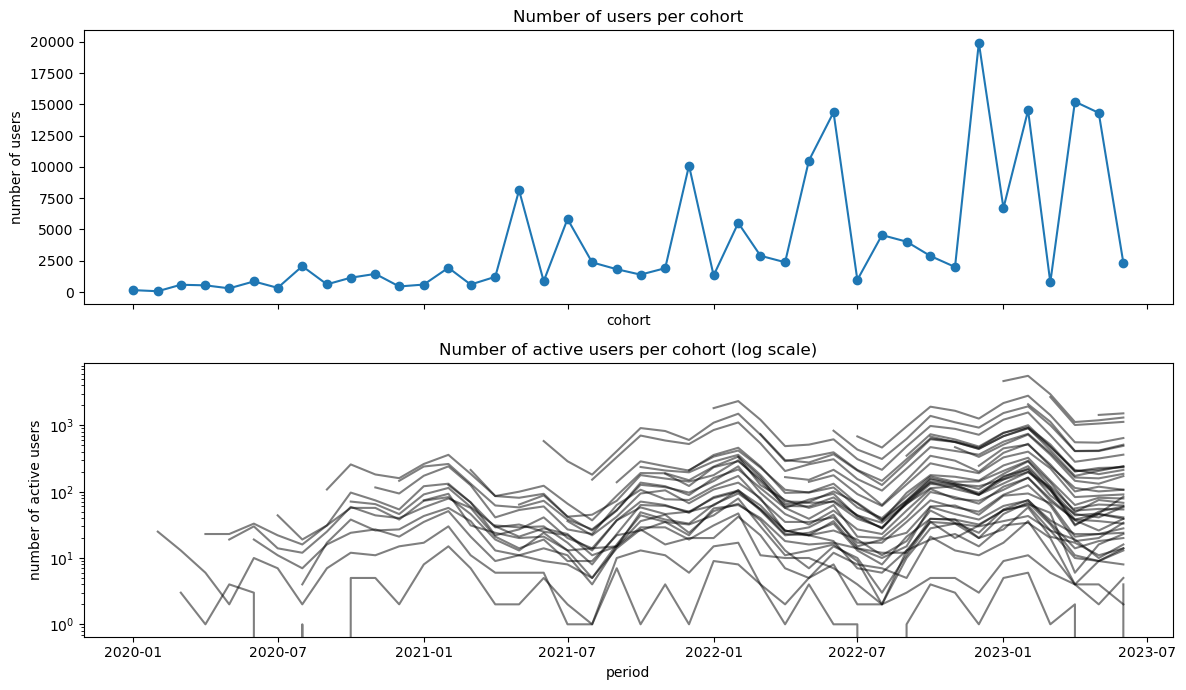

In [11]:
import matplotlib.pyplot as plt

# Create subplots with shared x-axis and different y-axes
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 7))

# Plot Number of users per cohort on the first subplot
cohort_users = train_data_df.drop_duplicates(subset=["cohort"]).set_index("cohort")
ax1.plot(cohort_users.index, cohort_users["n_users"], color="C0", marker="o")
ax1.set(title="Number of users per cohort", xlabel="cohort", ylabel="number of users")

# Plot Number of active users per cohort on the second subplot (log scale)
for cohort in train_data_df["cohort"].unique()[:-1]:
    active_users = train_data_df.query("cohort == @cohort and cohort_age > 0").set_index("period")["n_active_users"]
    ax2.plot(active_users.index, active_users.values, color="black", alpha=0.5)

ax2.set(
    title="Number of active users per cohort (log scale)",
    xlabel="period",
    ylabel="number of active users",
    yscale="log"
)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

- We observe a little positive trend in the number of users, with a few peaks that do not appear to be seasonal peaks.
- Number of repeat visitors: There is a definite seasonal component, peaking in the winter.


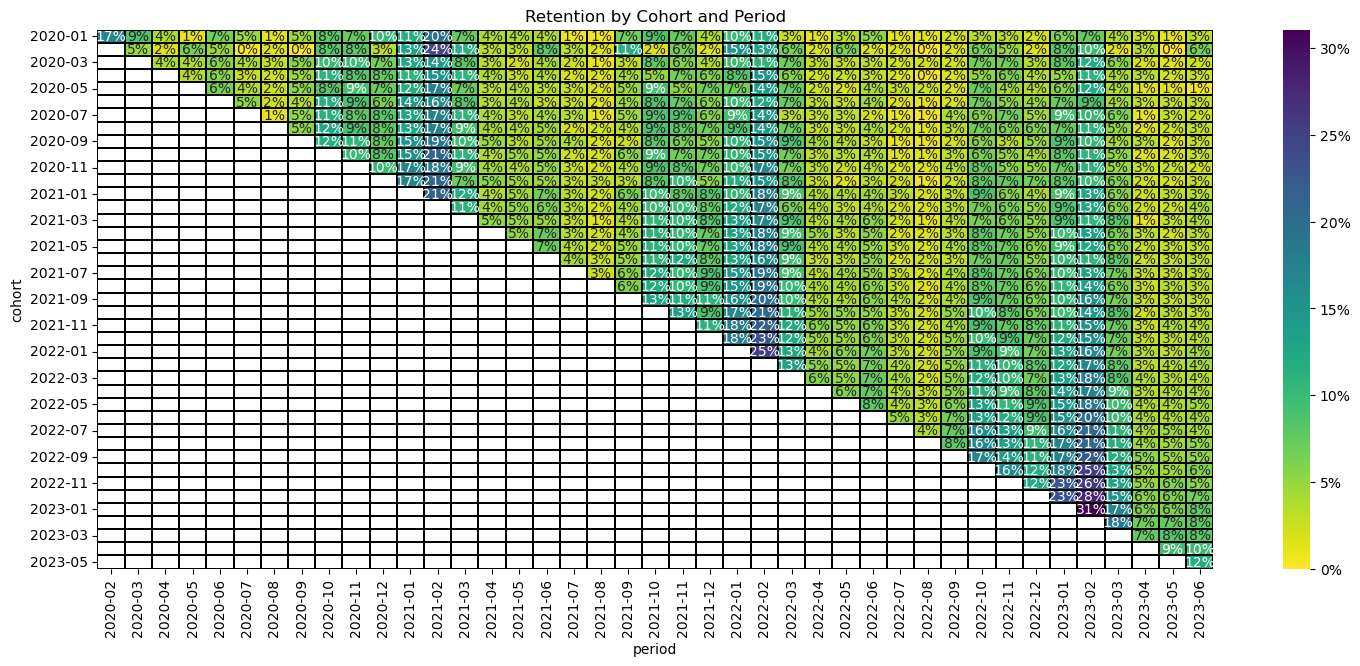

In [13]:
# plot the retention rates per cohort.

# Set figure size
plt.figure(figsize=(18, 7))

# Define a formatting function for percentage values
fmt = lambda y, _: f"{y :0.0%}"

# Prepare data for visualization
formatted_data = (
    train_data_df.loc[train_data_df["cohort_age"] != 0]
    .assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        period=lambda df: df["period"].dt.strftime("%Y-%m")
    )
    .pivot(index="cohort", columns="period", values="retention")
)

# Create a heatmap using Seaborn
sns.heatmap(
    data=formatted_data,
    cmap="viridis_r",
    linewidths=0.2,
    linecolor="black",
    annot=True,
    fmt="0.0%",
    cbar_kws={"format": mtick.FuncFormatter(fmt)}
)

# Set plot title
plt.title("Retention by Cohort and Period")

# Display the heatmap
plt.show()

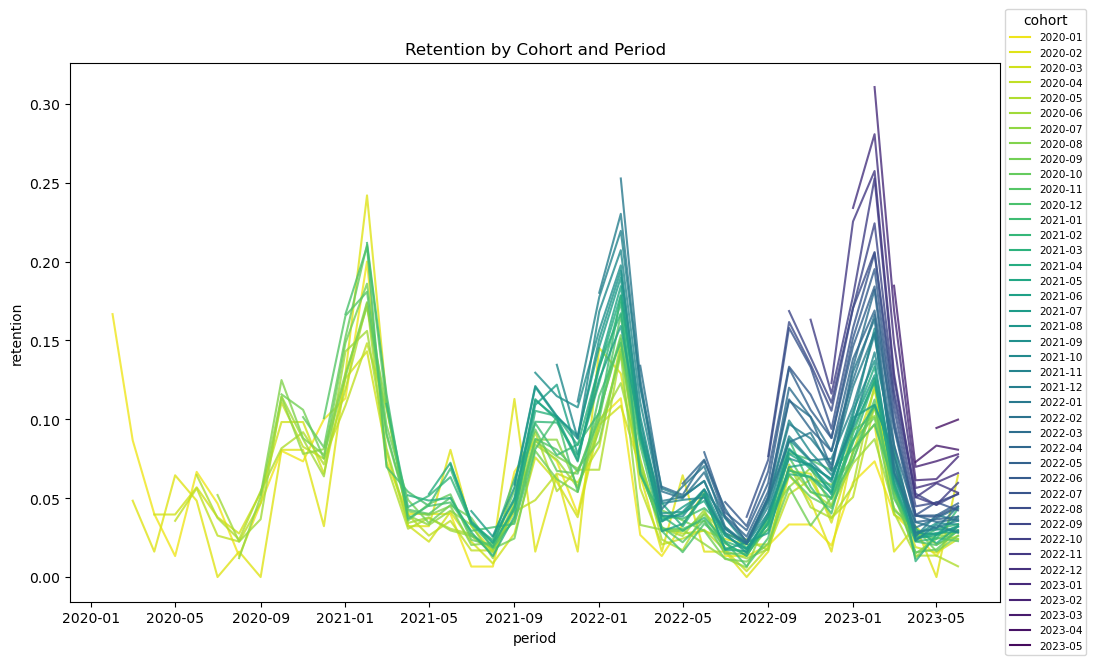

In [15]:
# Set the figure size
fig, ax = plt.subplots(figsize=(12, 7))

# Create a line plot with specified x, y, hue, palette, and transparency
sns.lineplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    alpha=0.8,
    data=train_data_df.query("cohort_age > 0").assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m")
    ),
    ax=ax,
)
# Customize the legend and its position
ax.legend(title="cohort", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set(title="Retention by Cohort and Period");

- The retention rates of the younger cohorts appear to be higher for a given time period than those of the older cohorts. 
- This makes it very evident that the retention rate depends on the absolute cohort age.
- The retention rates clearly have a seasonal component, as well.
- Seasonality maxima for a specific cohort are declining with time (period).



Let's take a closer look at this final point. We chart the monthly retention rates:

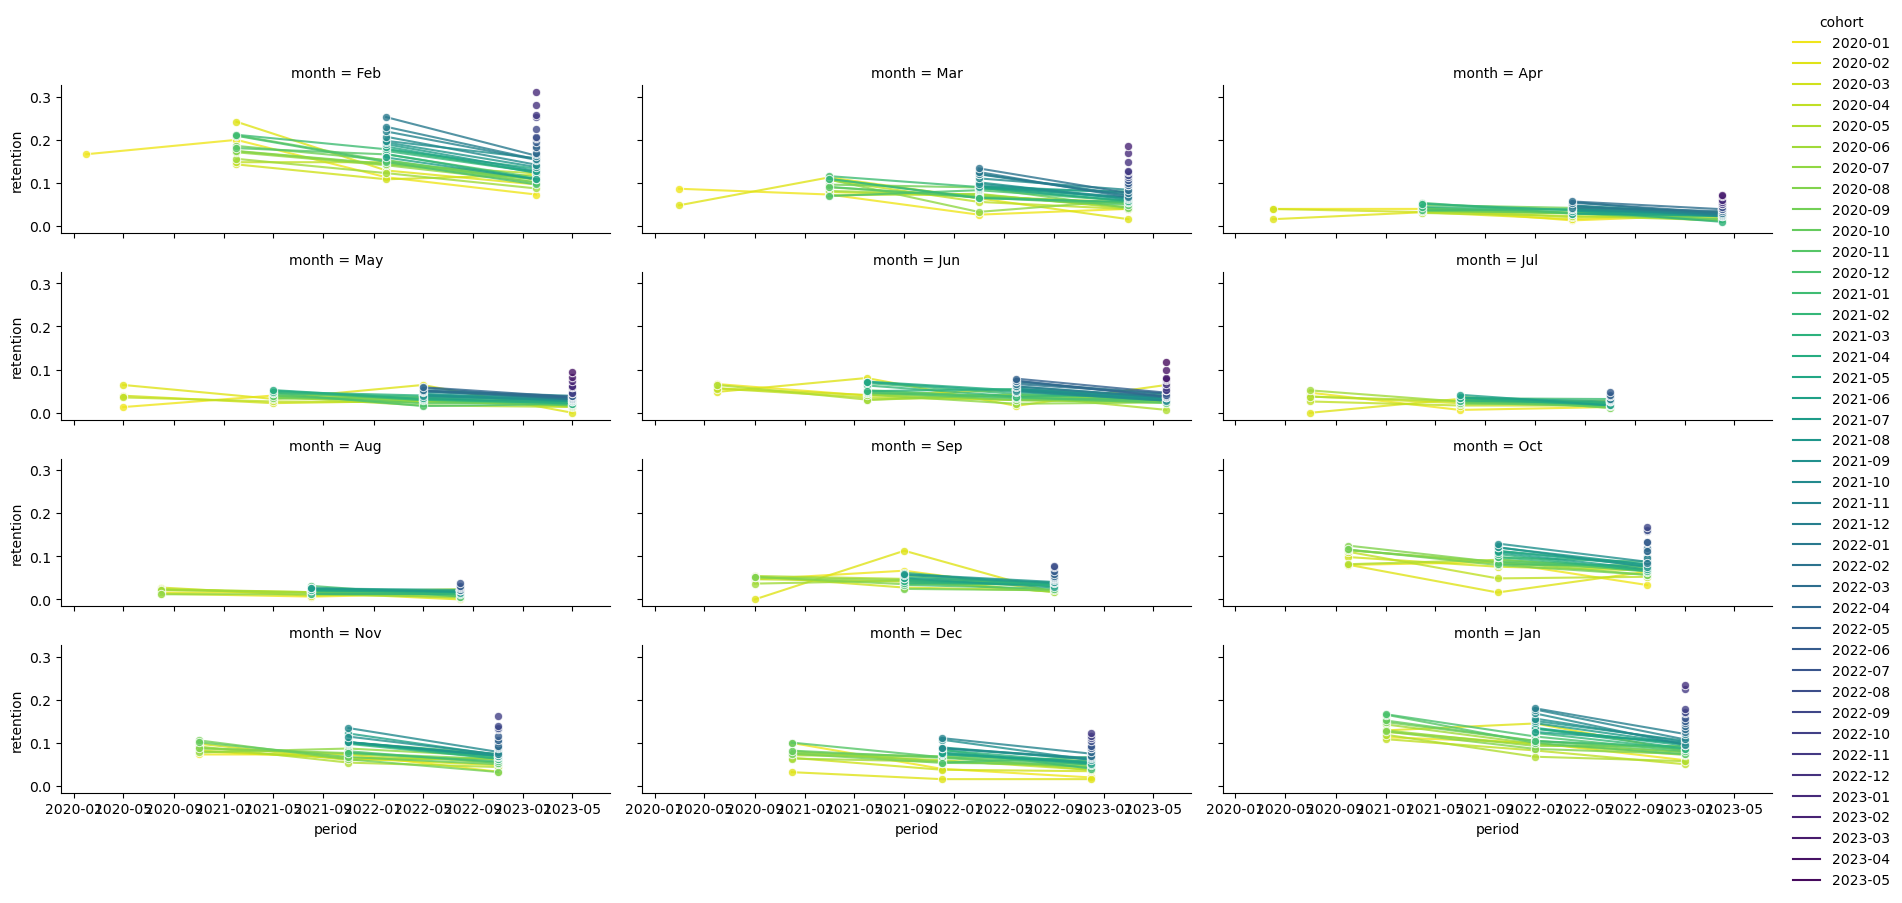

In [17]:
g = sns.relplot(
    x="period",
    y="retention",
    hue="cohort",
    palette="viridis_r",
    col="month",
    col_wrap=3,
    kind="line",
    marker="o",
    alpha=0.8,
    data=train_data_df.query("cohort_age > 0").assign(
        cohort=lambda df: df["cohort"].dt.strftime("%Y-%m"),
        month=lambda df: df["period"].dt.strftime("%b")
    ),
    height=2,
    aspect=3,
    facet_kws={"sharex": True, "sharey": True},
)

We plot the retention rates for each cohort (group of users who started using the product at the same time) at different observation times, as a function of the cohort age (i.e., how long the cohort has been using the product).

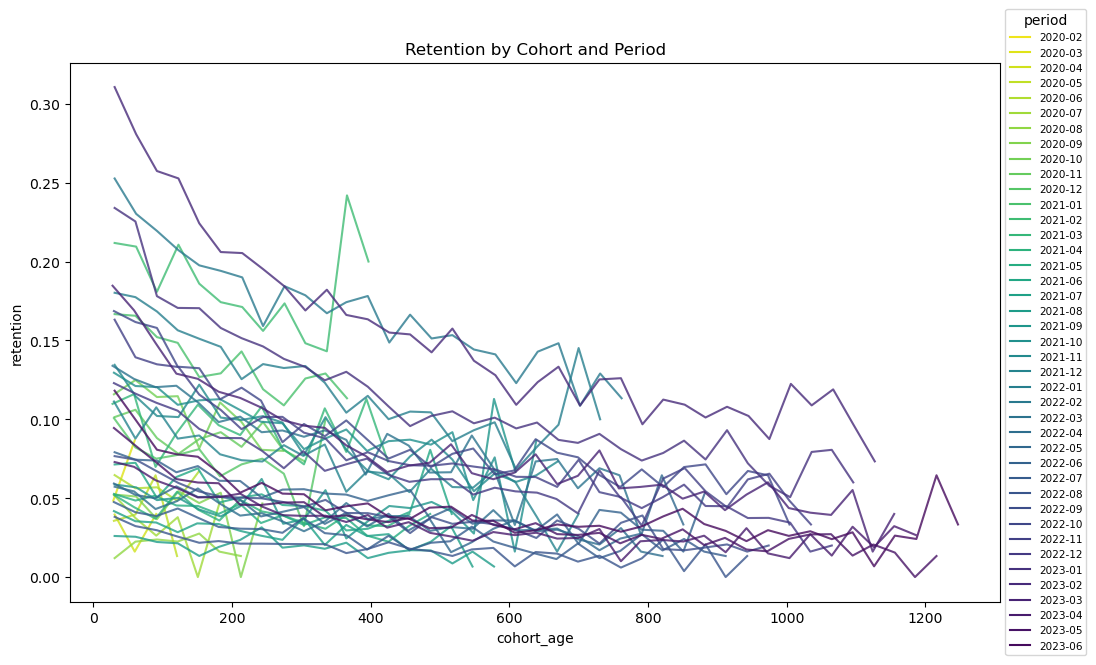

In [18]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(
    x="cohort_age",
    y="retention",
    hue="period",
    palette="viridis_r",
    alpha=0.8,
    data=train_data_df.query("cohort_age > 0").assign(
        period=lambda df: df["period"].dt.strftime("%Y-%m")
    ),
    ax=ax,
)
ax.legend(title="period", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=7.5)
ax.set(title="Retention by Cohort and Period");


- Most of the retention rates in the retention matrix above show a negative trend.
- The vertical columns in the retention matrix above show that most retention rates are decreasing over time.
- After controlling for seasonality, we can see that the retention rate is a function of both the absolute cohort age and the period, and there may also be an interaction effect between the two.
- One of the main takeaways from this EDA is that the retention rate is a function of the absolute cohort age and the period, with a potential interaction effect. This means that the retention rate for a given cohort will vary depending on how long ago the cohort joined and the current period.

### Modelling 

To model the retention rates, we will now use a generalized linear model with a binomial likelihood and a logit link function, based on the EDA above.

Seasonality We use dummy monthly indicators to model seasonality, which allows us to estimate the relative effect of each month on the outcome. We use a ZeroSumNormal distribution for these terms because we are interested in the relative effect, and we have an intercept in the model to account for the baseline.

Numerical variables We scale the numerical variables (cohort age and age) before modeling them.

In [20]:
train_data_red_df = train_data_df.query("cohort_age > 0").reset_index(drop=True)
train_obs_idx = train_data_red_df.index.to_numpy()
train_n_users = train_data_red_df["n_users"].to_numpy()
train_n_active_users = train_data_red_df["n_active_users"].to_numpy()
train_retention = train_data_red_df["retention"].to_numpy()

# Continuous features
train_age = train_data_red_df["age"].to_numpy()
train_age_scaler = StandardScaler(with_mean=False)
train_age_scaled = train_age_scaler.fit_transform(train_age.reshape(-1, 1)).flatten()
train_cohort_age = train_data_red_df["cohort_age"].to_numpy()
train_cohort_age_scaler = StandardScaler(with_mean=False)
train_cohort_age_scaled = train_cohort_age_scaler.fit_transform(
    train_cohort_age.reshape(-1, 1)
).flatten()

# Categorical features
train_cohort = train_data_red_df["cohort"].to_numpy()
train_cohort_encoder = LabelEncoder()
train_cohort_idx = train_cohort_encoder.fit_transform(train_cohort).flatten()
train_period = train_data_red_df["period"].to_numpy()
train_period_encoder = LabelEncoder()
train_period_idx = train_period_encoder.fit_transform(train_period).flatten()
train_period_month = train_data_red_df["period"].dt.month.to_numpy()
train_period_month_encoder = LabelEncoder()
train_period_month_idx = train_period_month_encoder.fit_transform(
    train_period_month
).flatten()

coords = {
    "period_month": train_period_month_encoder.classes_,
}

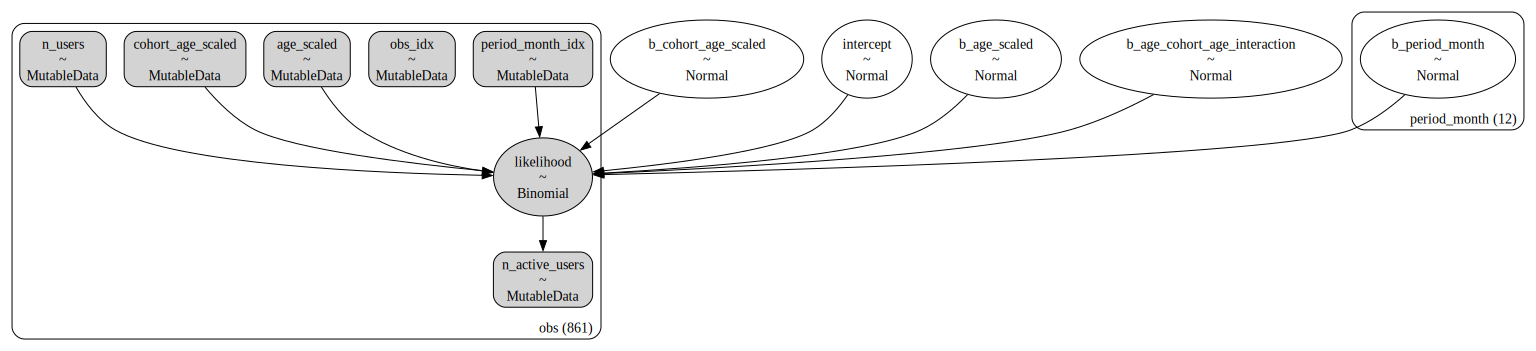

In [56]:
with pm.Model(coords=coords) as model:
    # --- Data ---
    obs_idx = pm.Data("obs_idx", train_obs_idx, dims="obs", mutable=True)
    age_scaled = pm.Data("age_scaled", train_age_scaled, dims="obs", mutable=True)
    cohort_age_scaled = pm.Data("cohort_age_scaled", train_cohort_age_scaled, dims="obs", mutable=True)
    period_month_idx = pm.Data("period_month_idx", train_period_month_idx, dims="obs", mutable=True)
    n_users = pm.Data("n_users", train_n_users, dims="obs", mutable=True)
    n_active_users = pm.Data("n_active_users", train_n_active_users, dims="obs", mutable=True)

    # --- Priors ---
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    b_age_scaled = pm.Normal("b_age_scaled", mu=0, sigma=1)
    b_cohort_age_scaled = pm.Normal("b_cohort_age_scaled", mu=0, sigma=1)
    b_period_month = pm.Normal("b_period_month", mu=0, sigma=1, dims="period_month")
    b_age_cohort_age_interaction = pm.Normal("b_age_cohort_age_interaction", mu=0, sigma=1)

    # --- Parametrization ---
    mu = intercept + b_age_scaled * age_scaled + b_cohort_age_scaled * cohort_age_scaled + \
         b_age_cohort_age_interaction * age_scaled * cohort_age_scaled + b_period_month[period_month_idx]

    p = pm.invlogit(mu)

    # --- Likelihood ---
    likelihood = pm.Binomial("likelihood", n=n_users, p=p, observed=n_active_users, dims="obs")

pm.model_to_graphviz(model=model)

### Model fitting

In [57]:
with model:
    idata = pm.sample(
        target_accept=0.8, draws=2_000, chains=4,
        nuts_sampler="numpyro",
        idata_kwargs={"likelihood": True},
        random_seed=42,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=42)

c:\Users\raviteja.kurva\Anaconda3\envs\pymc_env\Lib\site-packages\pymc\sampling\mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.941262
Sampling...


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]






Running chain 0:   0%|          | 0/3000 [00:04<?, ?it/s]

Running chain 0:   5%|▌         | 150/3000 [00:04<00:05, 545.73it/s]


Running chain 0:  10%|█         | 300/3000 [00:05<00:11, 228.37it/s]


Running chain 0:  15%|█▌        | 450/3000 [00:06<00:12, 200.16it/s]


Running chain 0:  20%|██        | 600/3000 [00:07<00:13, 173.69it/s]


Running chain 0:  25%|██▌       | 750/3000 [00:08<00:13, 166.22it/s]


Running chain 0:  30%|███       | 900/3000 [00:09<00:12, 169.80it/s]

Running chain 0:  35%|███▌      | 1050/3000 [00:10<00:11, 175.32it/s]


Running chain 0:  45%|████▌     | 1350/3000 [00:12<00:10, 158.39it/s]


Running chain 0:  50%|█████     | 1500/3000 [00:13<00:09, 166.53it/s]

Running chain 0:  55%|█████▌    | 1650/3000 [00:14<00:08, 168.47it/s]


Running chain 0:  65%|██████▌   | 1950/3000 [00:15<00:06, 167.20it/s]


Running chain 0:  70%|███████   | 2100/3000 [00:16<00:05, 161.39it/s]


Running chain 0:  75%|██

Sampling time =  0:00:27.449737
Transforming variables...
Transformation time =  0:00:00.008158


In [47]:
# get number of divergences
idata["sample_stats"]["diverging"].sum().item()

0

#### Model Diagnostics

In [48]:
varas = ['intercept', 'b_age_scaled', 'b_cohort_age_scaled', 'b_period_month', 'b_age_cohort_age_interaction']
az.summary(data=idata, var_names=varas)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-1.608,0.269,-2.112,-1.115,0.012,0.008,510.0,715.0,1.01
b_age_scaled,-0.208,0.004,-0.216,-0.200,0.000,0.000,2051.0,2554.0,1.00
b_cohort_age_scaled,-0.803,0.014,-0.828,-0.777,0.000,0.000,1258.0,1193.0,1.00
b_period_month[1],0.686,0.269,0.191,1.187,0.012,0.008,516.0,744.0,1.01
b_period_month[2],1.047,0.269,0.540,1.536,0.012,0.008,518.0,746.0,1.01
b_period_month[3],0.301,0.269,-0.189,0.806,0.012,0.008,517.0,757.0,1.01
b_period_month[4],-0.646,0.269,-1.140,-0.142,0.012,0.008,518.0,756.0,1.01
b_period_month[5],-0.543,0.269,-1.032,-0.034,0.012,0.008,515.0,753.0,1.01
b_period_month[6],-0.322,0.269,-0.840,0.160,0.012,0.008,517.0,747.0,1.01
b_period_month[7],-0.948,0.269,-1.430,-0.431,0.012,0.008,516.0,765.0,1.01


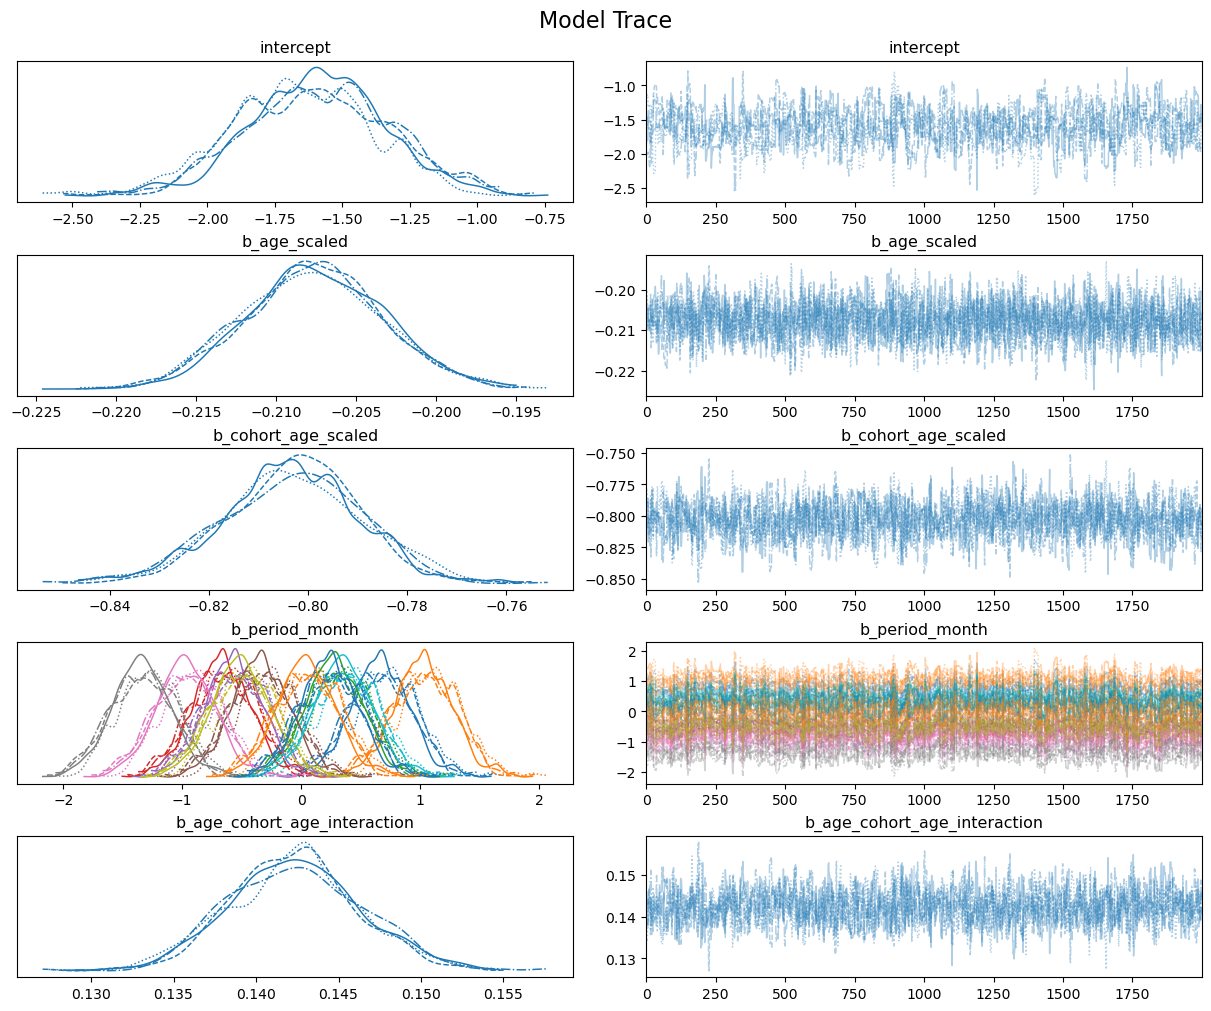

In [49]:
_ = az.plot_trace(
    data=idata,
    var_names=varas,
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

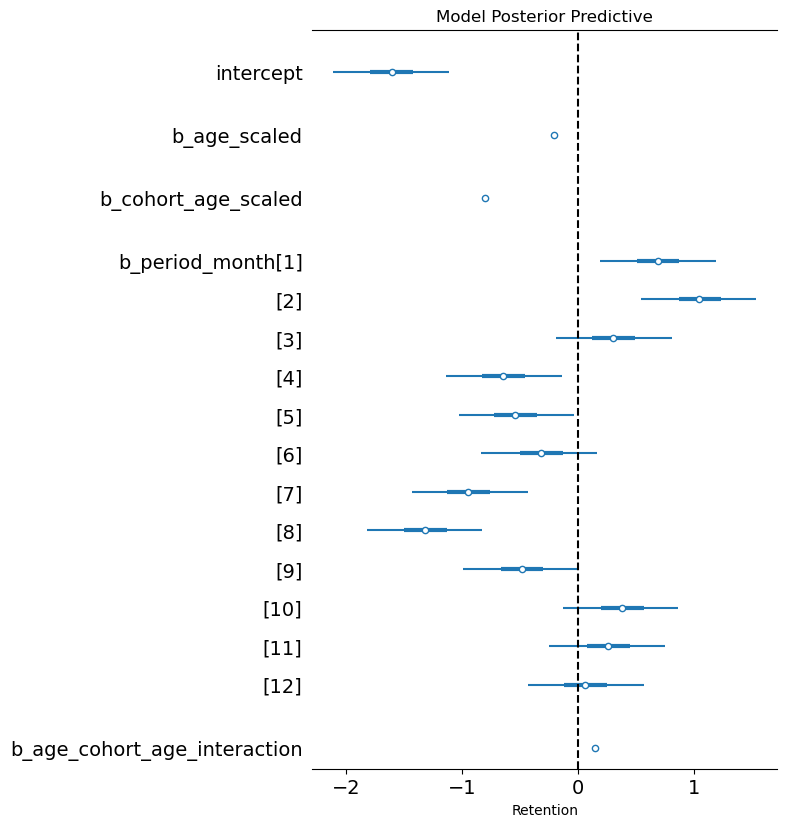

In [50]:
ax, *_ = az.plot_forest(data=idata, var_names=varas, combined=True)
ax.axvline(x=0, color="black", linestyle="--")
ax.set(title="Model Posterior Predictive", xlabel="Retention");

Now we will look into the posterior predictive check

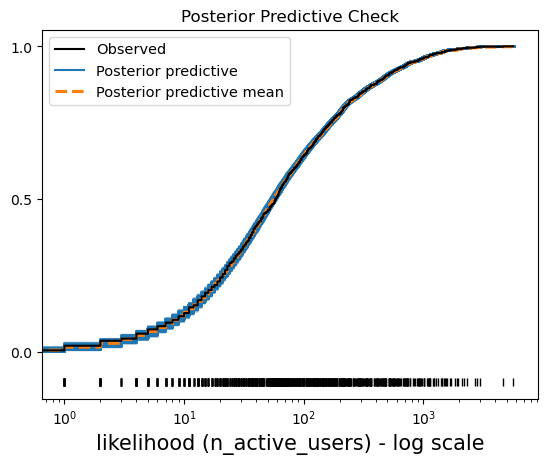

In [51]:
ax = az.plot_ppc(data=posterior_predictive, kind="cumulative", observed_rug=True)
ax.set(
    title="Posterior Predictive Check",
    xscale="log",
    xlabel="likelihood (n_active_users) - log scale",
);

We can now use the model to generate predictions of retention rates for the training data. We can then plot the observed retention rates and the predicted retention rates (also known as the posterior mean retention rates) to see how well the model fits the data.

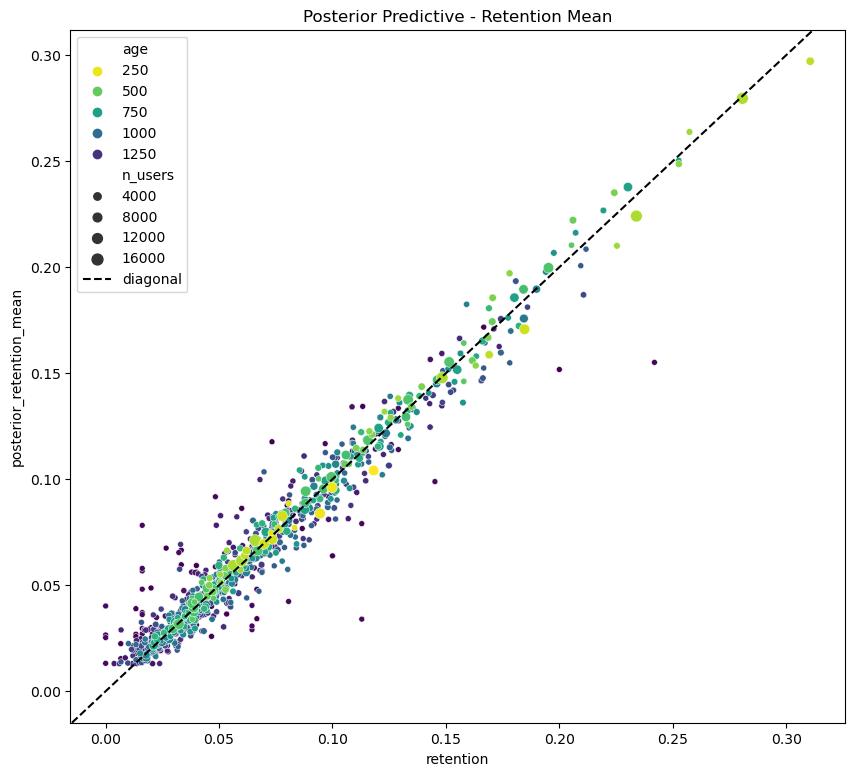

In [52]:
train_posterior_retention = (
    posterior_predictive.posterior_predictive / train_n_users[np.newaxis, None]
)
train_posterior_retention_mean = az.extract(
    data=train_posterior_retention, var_names=["likelihood"]
).mean("sample")

fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    x="retention",
    y="posterior_retention_mean",
    data=train_data_red_df.assign(
        posterior_retention_mean=train_posterior_retention_mean
    ),
    hue="age",
    palette="viridis_r",
    size="n_users",
    ax=ax,
)
ax.axline(xy1=(0, 0), slope=1, color="black", linestyle="--", label="diagonal")
ax.legend()
ax.set(title="Posterior Predictive - Retention Mean");

Model fit looks good 


Now, We see the predictions with Uncertainity 

C:\Users\raviteja.kurva\AppData\Local\Temp\ipykernel_8548\853341012.py:47: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


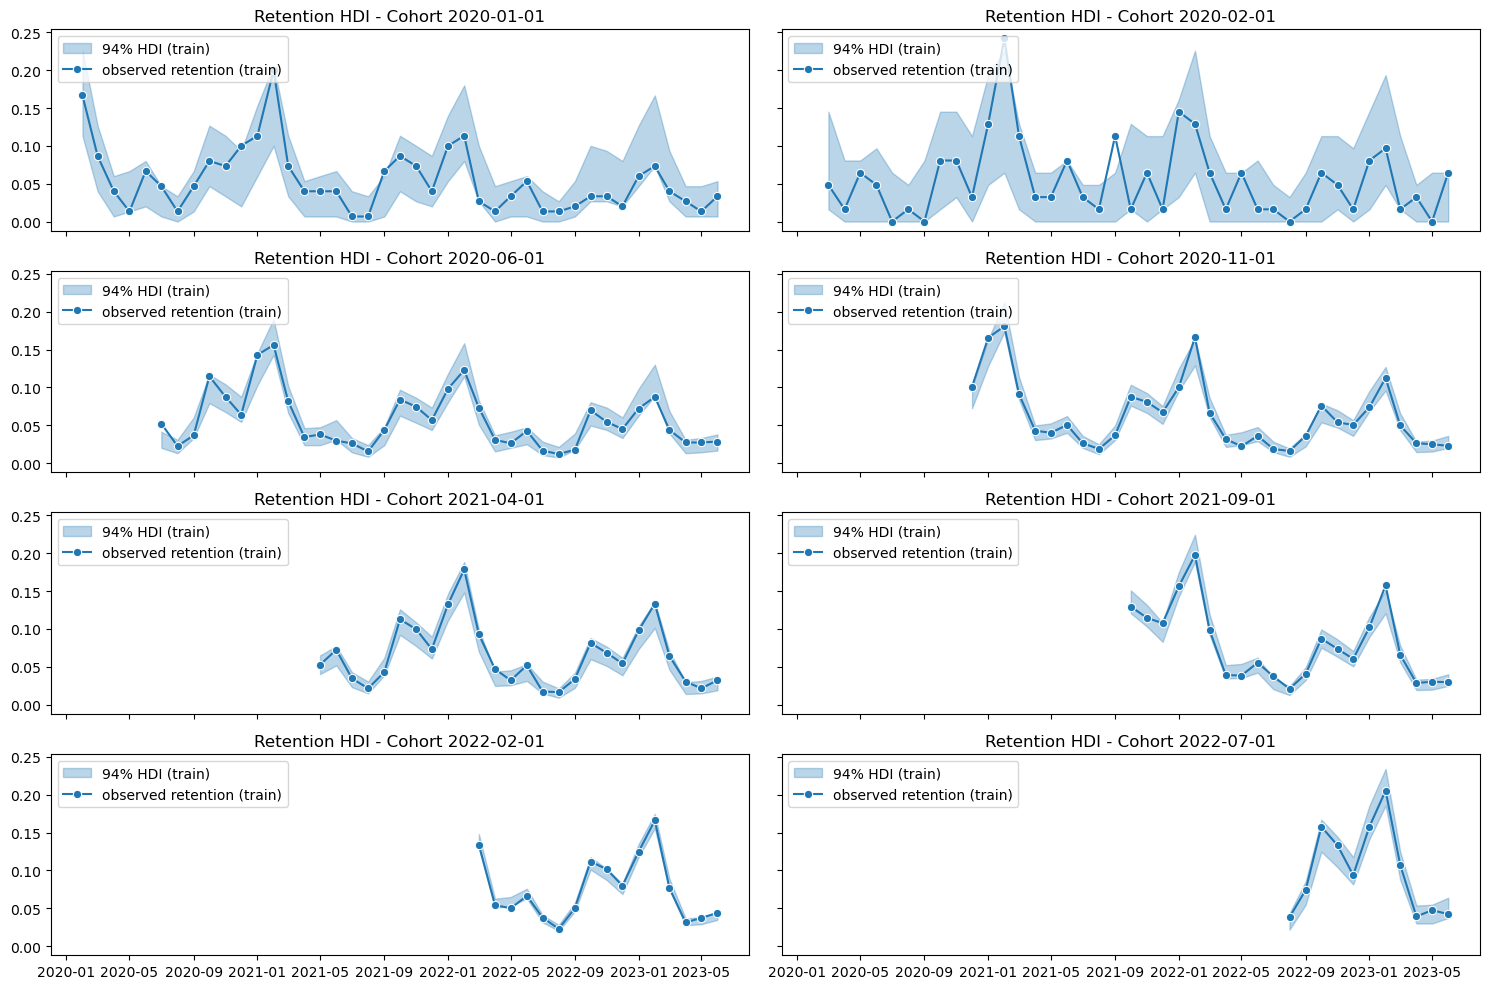

In [53]:
train_retention_hdi = az.hdi(ary=train_posterior_retention)["likelihood"]

def plot_train_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = train_cohort_idx == cohort_index
    cohort_period = train_period[train_period_idx[mask]]
    cohort_retention_hdi = train_retention_hdi[mask, :]

    ax.fill_between(
        x=cohort_period,
        y1=cohort_retention_hdi[:, 0],
        y2=cohort_retention_hdi[:, 1],
        alpha=0.3,
        color="C0",
        label="94% HDI (train)",
    )
    
    sns.lineplot(
        x=cohort_period,
        y=train_retention[mask],
        color="C0",
        marker="o",
        label="observed retention (train)",
        ax=ax,
    )
    
    cohort_date = pd.to_datetime(train_cohort_encoder.classes_[cohort_index]).date().isoformat()
    ax.legend(loc="upper left")
    ax.set(title=f"Retention HDI - Cohort {cohort_date}")
    return ax

cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

num_cols = 2
num_rows = int(np.ceil(len(cohort_index_to_plot) / num_cols))
fig, axes = plt.subplots(
    nrows=num_rows,
    ncols=num_cols,
    figsize=(15, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten()):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)

plt.tight_layout()
plt.show()

#### Predictions 
Let see the predictions on test dataset 

In [54]:
test_data_red_df = test_data_df.query("cohort_age > 0")
test_data_red_df = test_data_red_df[
    test_data_red_df["cohort"].isin(train_data_red_df["cohort"].unique())
].reset_index(drop=True)
test_obs_idx = test_data_red_df.index.to_numpy()
test_n_users = test_data_red_df["n_users"].to_numpy()
test_n_active_users = test_data_red_df["n_active_users"].to_numpy()
test_retention = test_data_red_df["retention"].to_numpy()

# Continuous features
test_cohort = test_data_red_df["cohort"].to_numpy()
test_cohort_idx = train_cohort_encoder.transform(test_cohort).flatten()
test_age = test_data_red_df["age"].to_numpy()
test_age_scaled = train_age_scaler.transform(test_age.reshape(-1, 1)).flatten()
test_cohort_age = test_data_red_df["cohort_age"].to_numpy()
test_cohort_age_scaled = train_cohort_age_scaler.transform(
    test_cohort_age.reshape(-1, 1)
).flatten()

# Categorical features
test_period_month = test_data_red_df["period"].dt.month.to_numpy()
test_period_month_idx = train_period_month_encoder.fit_transform(
    test_period_month
).flatten()

In [59]:
with model:
    pm.set_data({
        "obs_idx" : test_obs_idx,
        "age_scaled": test_age_scaled,
        "cohort_age_scaled": test_cohort_age_scaled,
        "period_month_idx": test_period_month_idx,
        "n_users": test_n_users,
        "n_active_users": np.ones_like(test_n_users)  # Dummy data for coordinates
    })

    prediction_coords = {"obs": test_obs_idx}

    # Sample from the posterior predictive distribution
    posterior_predictive = pm.sample_posterior_predictive(trace=idata,  random_seed=42)

## Extend the InferenceData object with the new samples
idata.extend(posterior_predictive)

Sampling: [likelihood]


we see the results on test dataset 

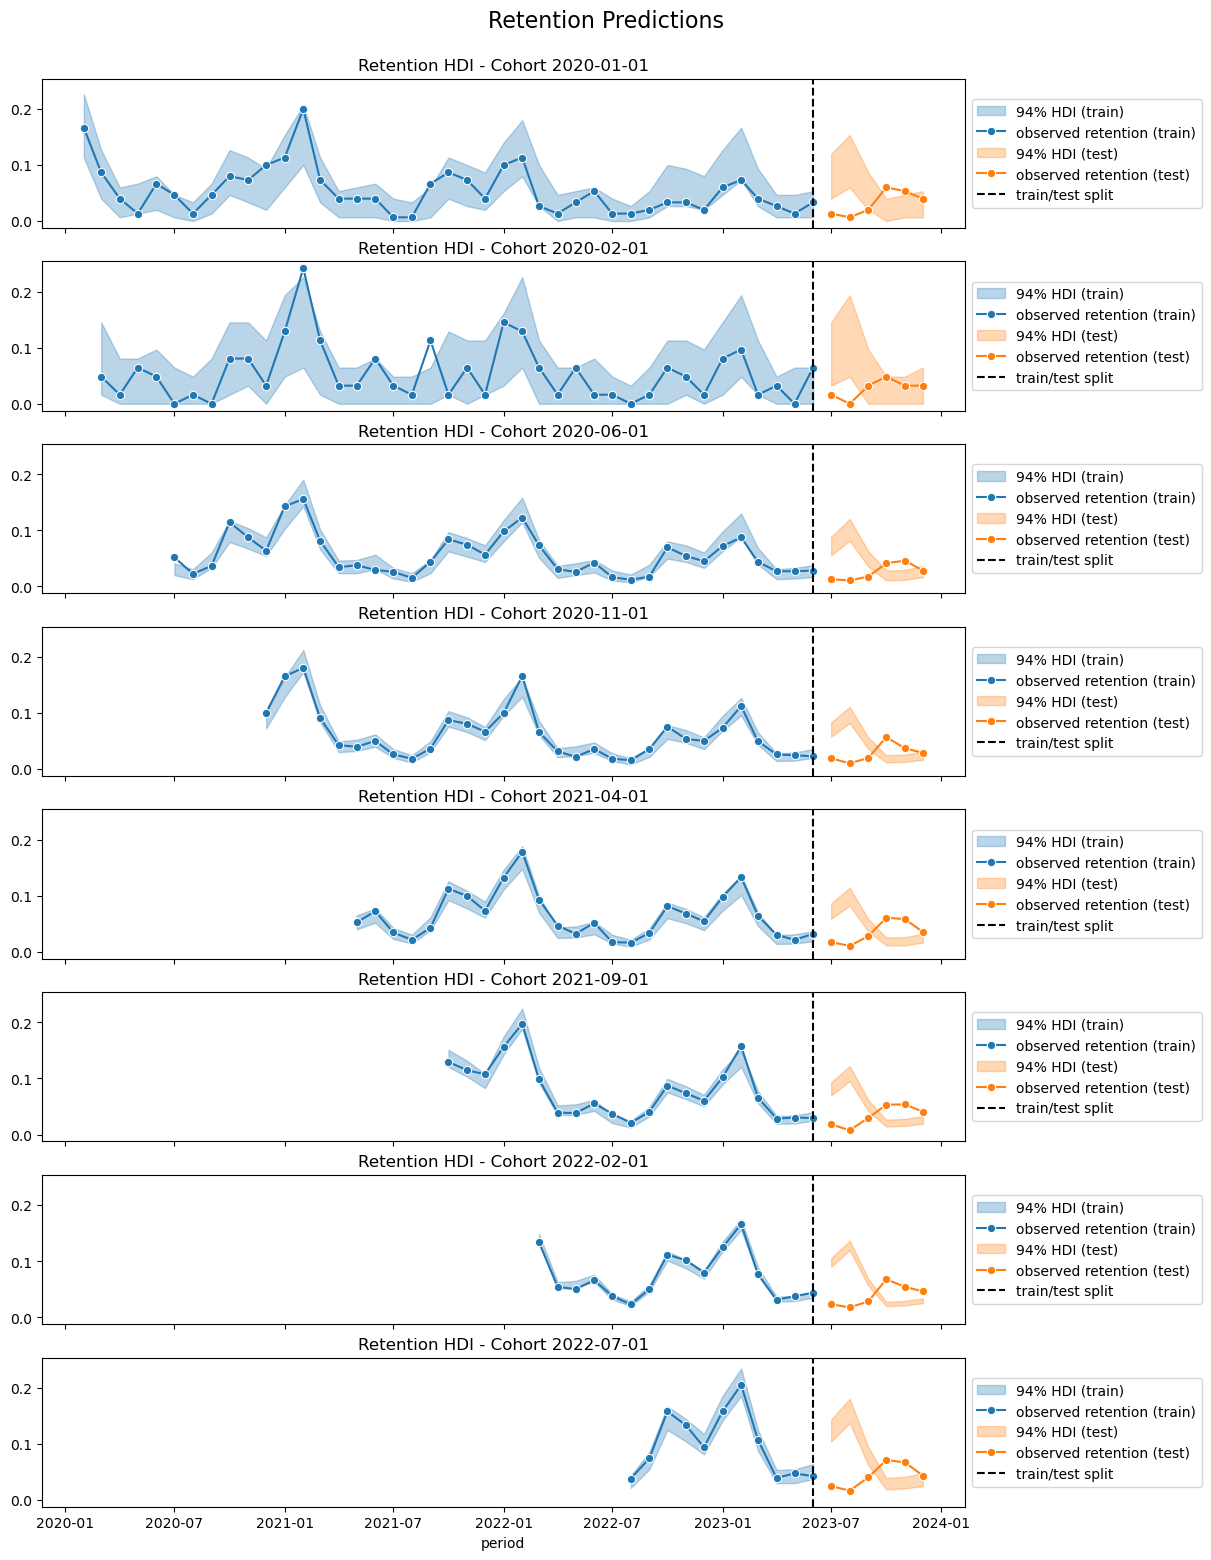

In [60]:
test_posterior_retention = (
    idata.posterior_predictive["likelihood"] / test_n_users[np.newaxis, None]
)

test_retention_hdi = az.hdi(ary=test_posterior_retention)["likelihood"]
def plot_test_retention_hdi_cohort(cohort_index: int, ax: plt.Axes) -> plt.Axes:
    mask = test_cohort_idx == cohort_index

    test_period_range = test_data_red_df.query(
        f"cohort == '{train_cohort_encoder.classes_[cohort_index]}'"
    )["period"]

    ax.fill_between(
        x=test_period_range,
        y1=test_retention_hdi[mask, :][:, 0],
        y2=test_retention_hdi[mask, :][:, 1],
        alpha=0.3,
        color="C1",
        label="94% HDI (test)",
    )
    sns.lineplot(
        x=test_period_range,
        y=test_retention[mask],
        color="C1",
        marker="o",
        label="observed retention (test)",
        ax=ax,
    )
    return ax
cohort_index_to_plot = [0, 1, 5, 10, 15, 20, 25, 30]

fig, axes = plt.subplots(
    nrows=len(cohort_index_to_plot),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for cohort_index, ax in zip(cohort_index_to_plot, axes.flatten()):
    plot_train_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    plot_test_retention_hdi_cohort(cohort_index=cohort_index, ax=ax)
    ax.axvline(
        x=pd.to_datetime(period_train_test_split),
        color="black",
        linestyle="--",
        label="train/test split",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig.suptitle("Retention Predictions", y=1.03, fontsize=16);

The out-of-sample predictions does not looks good on test data

I believe that this model will be a base foundation for improving the performance of our real-world datasets. For example, use other/complex model.